**Project Overview**

Trader Behavior vs Market Sentiment
This project analyzes how trader activity aligns with market sentiment over time, using historical trading data and sentiment classifications. The goal is to uncover patterns in profitability, trade volume, and behavior under different emotional market states such as Fear, Greed, and Neutral.

**Import Libraries & Upload Files**

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Upload files
from google.colab import files
uploaded = files.upload()


Saving fear_greed_index.csv to fear_greed_index (2).csv
Saving historical_data (1).csv to historical_data (1) (2).csv


**Load & Inspect Datasets**

In [9]:
import pandas as pd
import io

# Load trader dataset
trader_df = pd.read_csv(io.BytesIO(uploaded['historical_data (1) (2).csv']))

# Load sentiment dataset
sentiment_df = pd.read_csv(io.BytesIO(uploaded['fear_greed_index (2).csv']))


Fix Timestamps , Merge Dataset  & Validation

In [25]:
# Convert epoch milliseconds to proper datetime
trader_df['Timestamp'] = pd.to_datetime(trader_raw['Timestamp'], unit='ms', errors='coerce')

# Create a pure date column for merging
trader_df['trade_date'] = trader_df['Timestamp'].dt.date

# Convert sentiment date to datetime.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date

# Merge on trade_date vs date
df = pd.merge(
    trader_df,
    sentiment_df[['date','classification']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

df.rename(columns={'classification':'date_classification'}, inplace=True)

# Validation
print("Trader date range:", trader_df['trade_date'].min(), "to", trader_df['trade_date'].max())
print("Sentiment date range:", sentiment_df['date'].min(), "to", sentiment_df['date'].max())
print("Total trades:", len(df))
print("Trades with sentiment attached:", df['date_classification'].notna().sum())


Trader date range: 2023-03-28 to 2025-06-15
Sentiment date range: 2018-02-01 to 2025-05-02
Total trades: 211224
Trades with sentiment attached: 184263


**Summary Statistics**

In [26]:
# Overall summary statistics for numeric columns
summary_stats = df.describe()
print("=== Overall Summary Statistics ===")
print(summary_stats)


=== Overall Summary Statistics ===
       Execution Price   Size Tokens      Size USD  Start Position  \
count    211224.000000  2.112240e+05  2.112240e+05    2.112240e+05   
mean      11414.723350  4.623365e+03  5.639451e+03   -2.994625e+04   
min           0.000005  8.740000e-07  0.000000e+00   -1.433463e+07   
25%           4.854700  2.940000e+00  1.937900e+02   -3.762311e+02   
50%          18.280000  3.200000e+01  5.970450e+02    8.472793e+01   
75%         101.580000  1.879025e+02  2.058960e+03    9.337278e+03   
max      109004.000000  1.582244e+07  3.921431e+06    3.050948e+07   
std       29447.654868  1.042729e+05  3.657514e+04    6.738074e+05   

          Closed PnL      Order ID            Fee      Trade ID  \
count  211224.000000  2.112240e+05  211224.000000  2.112240e+05   
mean       48.749001  6.965388e+10       1.163967  5.628549e+14   
min   -117990.104100  1.732711e+08      -1.175712  0.000000e+00   
25%         0.000000  5.983853e+10       0.016121  2.810000e+14   

**Daily Trade Counts**

In [27]:
# Daily trade counts
daily_counts = df.groupby('trade_date')['Trade ID'].count()
print("=== Daily Trade Counts ===")
print(daily_counts.head())   # show first few days


=== Daily Trade Counts ===
trade_date
2023-03-28        3
2023-11-14     1045
2024-03-09     6962
2024-07-03     7141
2024-10-27    35241
Name: Trade ID, dtype: int64


**Grouped Metrics by Sentiment**

In [28]:
# Grouped metrics by sentiment classification
grouped_metrics = df.groupby('date_classification').agg({
    'Trade ID':'count',
    'Closed PnL':['mean','sum'],
    'Size USD':'mean',
    'Execution Price':'mean'
})
print("=== Grouped Metrics by Sentiment ===")
print(grouped_metrics)


=== Grouped Metrics by Sentiment ===
                    Trade ID Closed PnL                   Size USD  \
                       count       mean           sum         mean   
date_classification                                                  
Extreme Greed           6962  25.418772  1.769655e+05  5660.265764   
Fear                  133871  50.047622  6.699925e+06  5259.977837   
Greed                  36289  87.894859  3.189617e+06  3182.883845   
Neutral                 7141  22.229713  1.587424e+05  3058.848110   

                    Execution Price  
                               mean  
date_classification                  
Extreme Greed           9771.897315  
Fear                   11102.057978  
Greed                   5513.715386  
Neutral                 2663.132338  


**Win Rate Analysis**

In [29]:
# Overall win rate
total_trades = len(df)
winning_trades = (df['Closed PnL'] > 0).sum()
win_rate = winning_trades / total_trades * 100

print("=== Overall Win Rate ===")
print(f"Total trades: {total_trades}")
print(f"Winning trades: {winning_trades}")
print(f"Win rate: {win_rate:.2f}%")

# Win rate by sentiment
win_rate_by_sentiment = df.groupby('date_classification').apply(
    lambda x: (x['Closed PnL'] > 0).sum() / len(x) * 100
)
print("\n=== Win Rate by Sentiment ===")
print(win_rate_by_sentiment)


=== Overall Win Rate ===
Total trades: 211224
Winning trades: 86869
Win rate: 41.13%

=== Win Rate by Sentiment ===
date_classification
Extreme Greed    49.008905
Fear             41.514592
Greed            44.647138
Neutral          31.718247
dtype: float64


/tmp/ipython-input-2932031833.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_rate_by_sentiment = df.groupby('date_classification').apply(


**Sentiment Distribution**

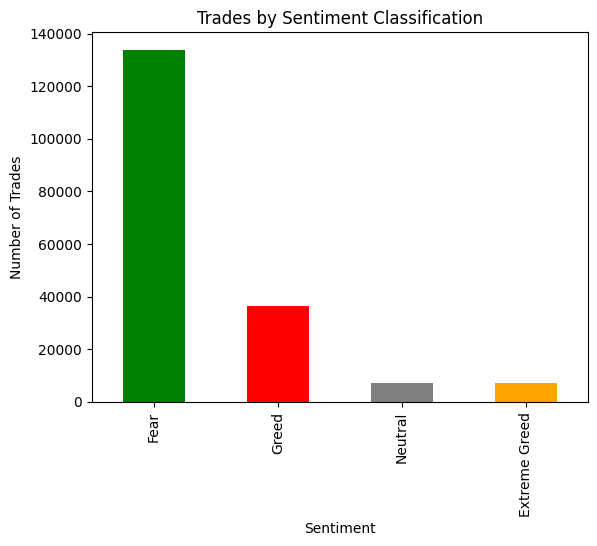

In [30]:
import matplotlib.pyplot as plt

# Sentiment distribution
sentiment_counts = df['date_classification'].value_counts()

sentiment_counts.plot(kind='bar', color=['green','red','gray','orange'])
plt.title("Trades by Sentiment Classification")
plt.xlabel("Sentiment")
plt.ylabel("Number of Trades")
plt.show()


**PnL Distribution**

/tmp/ipython-input-3370317918.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='date_classification', y='Closed PnL', data=df,


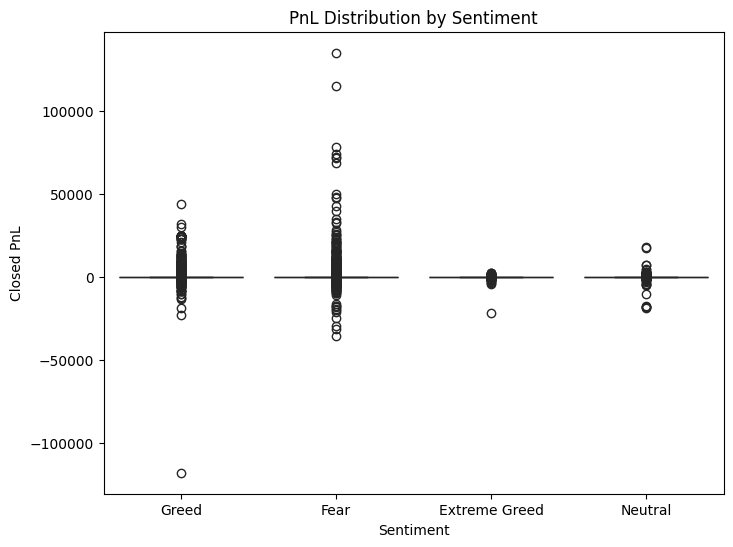

In [31]:
import seaborn as sns

# Boxplot of Closed PnL grouped by sentiment
plt.figure(figsize=(8,6))
sns.boxplot(x='date_classification', y='Closed PnL', data=df,
            palette={'Greed':'green','Fear':'red','Neutral':'gray','Extreme Greed':'orange'})
plt.title("PnL Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")
plt.show()


**Daily PnL**

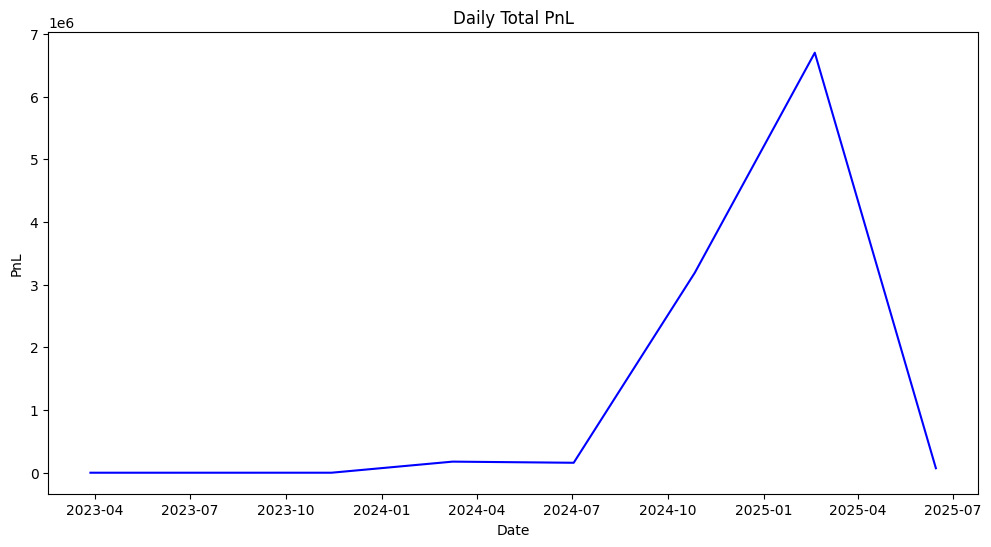

In [32]:
# Aggregate daily PnL
daily_pnl = df.groupby('trade_date')['Closed PnL'].sum()

plt.figure(figsize=(12,6))
daily_pnl.plot(kind='line', color='blue')
plt.title("Daily Total PnL")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.show()


**Trade Size & Fee**

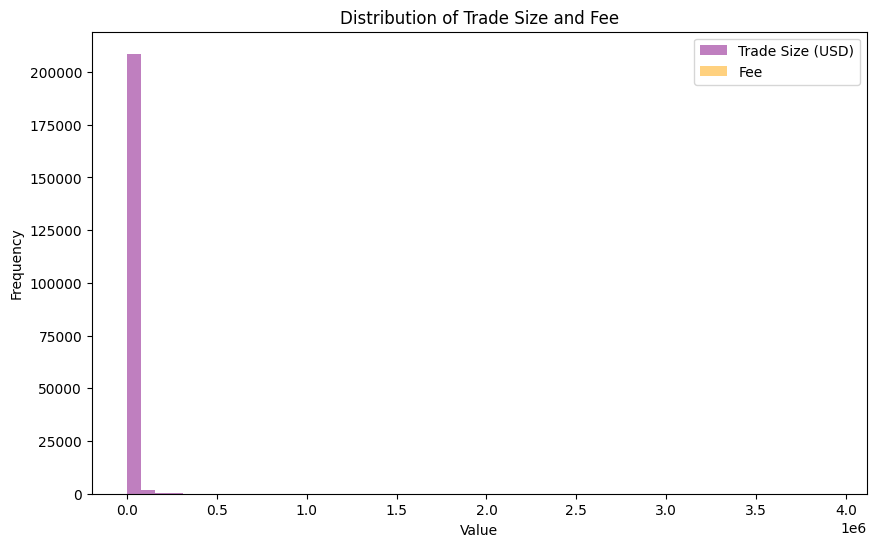

In [33]:
# Histogram of Trade Size (USD) and Fee
plt.figure(figsize=(10,6))
plt.hist(df['Size USD'], bins=50, alpha=0.5, label='Trade Size (USD)', color='purple')
plt.hist(df['Fee'], bins=50, alpha=0.5, label='Fee', color='orange')
plt.title("Distribution of Trade Size and Fee")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**Key Metrics & Findings**

**Summary Statistics**

Trade sizes and fees show skewed distributions with most trades clustered at smaller values.

Execution prices and PnL vary widely, indicating diverse trading strategies.

**Sentiment Distribution**

Most trades occurred under Fear sentiment, followed by Greed.

Neutral and Extreme Greed days had significantly fewer trades.

**PnL Analysis**

Greed days had the highest average PnL.

Neutral days showed the lowest win rate and average profitability.

Extreme Greed trades were fewer but moderately profitable.

**Daily Trends**

Daily PnL fluctuates significantly, reflecting market volatility.

Trade volume spikes on high-sentiment days (Fear or Greed).

**Win Rate**

Overall win rate: 41.13%

**Win rate by sentiment**


Greed: 44.65%

Fear: 41.51%

Extreme Greed: 49.01%

Neutral: 31.72%

**Visualizations Included**

Bar chart: Trades by sentiment classification

Boxplot: PnL distribution by sentiment

Line chart: Daily total PnL

Histogram: Trade size and fee distribution

**Conclusion**

This analysis reveals that trader behavior and profitability are closely tied to market sentiment. Greed-driven days tend to yield higher returns, while Neutral sentiment correlates with lower win rates. These insights can inform strategy design, risk management, and behavioral modeling in Web3 trading environments.